In [1]:
from glob import glob
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import helper
traj = helper.build_anatoli_trajcetory()

In [3]:
from neutrino_level.steps.general_modules.read_data import load_dfs
mc_df, data_df = load_dfs(
    traj, ignore_tables=helper.to_ignore)

Loading comp: juliet_numu


 74%|███████▍  | 65/88 [00:00<00:00, 132.49Observables/s]

Skipping to load I3MCWeightDict!


 90%|████████▉ | 79/88 [00:00<00:00, 91.49Observables/s] 

Skipping to load NuTauProperties!
Skipping to load NuEProperties!
Unduplicating Table for EHEMuMillipede_SplineMPEseed_vecd.vector_index


 92%|█████████▏| 81/88 [00:10<00:00,  7.96Observables/s]

Skipping to load I3JulietPrimaryParticle!
(1400001, 0, 0)


juliet_numu: 1st index 1, 0, 0
juliet_numu: 1st index srt 1, 0, 0
Loading comp: corsika


 98%|█████████▊| 81/83 [00:44<00:01,  1.30Observables/s]

Unduplicating Table for EHEMuMillipede_SplineMPEseed_vecd.vector_index


100%|██████████| 83/83 [11:08<00:00,  8.06s/Observables]


(2300001, 6, 0)
Found corsika component!
< GenerationSurface
           PPlus : N=57052539.2 PowerLaw(-2.0 ,1000000.0, 10000000000.0) NaturalRateCylinder(1200.0, 600.0, 0.00017457020856805793, 1.0)
                   N=9992000.0 PowerLaw(-1.5 ,100000.0, 1000000000.0) NaturalRateCylinder(1200.0, 600.0, 0.00017457020856805793, 1.0)
                   N=9969.0 PowerLaw(-1.5 ,1000000000.0, 99999997952.0) NaturalRateCylinder(1200.0, 600.0, 0.00017457020856805793, 1.0)
                   N=98410.0 PowerLaw(-2.0 ,200000000.0, 20000000000.0) NaturalRateCylinder(1200.0, 600.0, 0.00017457020856805793, 1.0)
      He4Nucleus : N=28506307.200000003 PowerLaw(-2.0 ,1000000.0, 10000000000.0) NaturalRateCylinder(1200.0, 600.0, 0.00017457020856805793, 1.0)
      N14Nucleus : N=17127739.200000003 PowerLaw(-2.0 ,1000000.0, 10000000000.0) NaturalRateCylinder(1200.0, 600.0, 0.00017457020856805793, 1.0)
     Al27Nucleus : N=11418492.8 PowerLaw(-2.0 ,1000000.0, 10000000000.0) NaturalRateCylinder(1200.0, 600.0

In [4]:
from stochasticity_observable_ import get_1d_rlogl
from stochasticity_observable_ import spline, Likelihood_1D

sys.path.append('/Users/brianclark/Documents/work/IceCube/ehe/ehe_deps/energy_loss_pdfs')
from likelihood import Likelihood_1D

get_1d_rlogl(
    mc_df,
    Likelihood_1D(spline),
    table_name='EHEMuMillipede_SplineMPEseed_vecd',
    key_name='stochasticity',
    min_bins=8,
    n_bins_to_combine=4)

In [5]:
stoch_thresh = 8.374043045935741
rlogl_mask = mc_df['stochasticity'] >= stoch_thresh

In [6]:
def track_quality_cut(speed=None, npe=None,
                      charge_scale=1.):
    '''
    Input: np.ndarrays of values to base the cut on
    Returns: mask, where "True" indicates an event *PASSES* the cut
    '''
    # pass charge cut
    mask1 = npe > (10**4.65 * charge_scale)
    
    # does *NOT* pass the track speed cut below 0.26 (cascade like)
    low_speed = speed <= 0.26
    low_mask = np.logical_and(low_speed, npe < (10**5.25 * charge_scale))
    
    # does *NOT* pass the track speed cut between 0.26 and 0.28
    intermediate_speed = np.logical_and(speed > 0.26,
                                    speed < 0.28)
    intermediate_charge_thresh = (
        np.power(10, 5.25 - (0.6/0.02) * (speed - 0.26)))
    intermediate_mask = np.logical_and(
        intermediate_speed,
        npe < (intermediate_charge_thresh * charge_scale))
      
    # total mask (mask1 and NOT low mask and NOT intermediate mask)
    total_mask = np.logical_and(
        mask1, ~intermediate_mask
    )
    total_mask = np.logical_and(
       total_mask, ~low_mask 
    )
    return total_mask


def muon_bundle_cut_stoch_opt(
        mc_df,
        reco_zen_key='EHEOpheliaParticleSRT_ImpLF.zenith',
        npe_key='EHEPortiaEventSummary.atwdNPEbtw',
        inplace=False,
        charge_scale=1.,
        floor=4.55,
        ceil=6.05,
        denom=0.9,
        inflection_point=0.1,
        pwr=2.5):
    # Apply base cut
    mask = mc_df[npe_key] >= (10**floor * charge_scale)
    
    # Add zenith dependent npe cut
    above_horizon = np.cos(mc_df[reco_zen_key]) >= inflection_point
    npe_thresh = np.power(10, floor + (ceil-floor) *
                          np.sqrt(1 - np.power((1-np.cos(mc_df[reco_zen_key]))/denom, pwr)))
    npe_mask = np.logical_and(
        above_horizon,
        mc_df[npe_key] < (npe_thresh * charge_scale))
    mask = np.logical_and(mask, ~npe_mask)
    return mask

In [7]:
params_low = {
    'floor': 4.7,
    'inflection_point': 0.1,
    'ceil': 6.25,
    'denom': 0.9,
    'pwr': 1.5
}

params_high = {
    'floor': 4.65,
    'inflection_point': 0.1,
    'ceil': 5.7,
    'denom': 0.9,
    'pwr': 4
}


In [8]:

charge_scale = 1.27 * 0.94

bundle_mask_low = np.logical_and(
    muon_bundle_cut_stoch_opt(
        mc_df,
        reco_zen_key='EHE_SplineMPE.zenith',
        npe_key='Homogenized_QTot.value',
        charge_scale=charge_scale,
        **params_low
    ),
    ~rlogl_mask
)

bundle_mask_high = np.logical_and(
    muon_bundle_cut_stoch_opt(
        mc_df,
        reco_zen_key='EHE_SplineMPE.zenith',
        npe_key='Homogenized_QTot.value',
        charge_scale=charge_scale,
        **params_high
    ),
    rlogl_mask
)

bundle_mask = np.logical_or(
    bundle_mask_low,
    bundle_mask_high
)

track_quality_mask = track_quality_cut(
    mc_df['EHELineFit.speed'],
    mc_df['Homogenized_QTot.value'],
    charge_scale=charge_scale
)

pass_L3 = track_quality_mask

selection_mask = np.logical_and(
    bundle_mask,
    track_quality_mask
)

pass_L4 = selection_mask

In [9]:
# the juliet weights

from neutrino_level.steps.general_modules.label_maker import type_to_label

def get_idx_from_comp(df, comp):
    idx = np.array(df['Label'] == type_to_label[comp], dtype=bool)
    return idx

juliet_weights_L2 = np.asarray([])
juliet_charge_L2 = np.asarray([])

juliet_weights_L3 = np.asarray([])
juliet_charge_L3 = np.asarray([])

juliet_weights_L4 = np.asarray([])
juliet_charge_L4 = np.asarray([])

charge_var = 'Homogenized_QTot.value'
weighting_strat = 'Weights.ahlers_gzk'

components = ['nue_cc', 'numu_cc', 'nutau_cc', 'neutrino_nc', 'nue_gr']
for comp in components:
    
    mc_pass_L2 = mc_df
    mc_pass_L3 = mc_df.loc[pass_L3]
    mc_pass_L4 = mc_df.loc[pass_L4]
    
    # L2
    comp_idx = get_idx_from_comp(mc_pass_L2, comp)
    juliet_values_pass_L2 = mc_pass_L2.loc[comp_idx, charge_var]
    juliet_weights_pass_L2 = mc_pass_L2.loc[comp_idx, weighting_strat] * np.pi * 1E7 # per year
    juliet_weights_L2 = np.concatenate((juliet_weights_L2, juliet_weights_pass_L2))
    juliet_charge_L2 = np.concatenate((juliet_charge_L2, juliet_values_pass_L2))
    
    # L3
    comp_idx = get_idx_from_comp(mc_pass_L3, comp)
    juliet_values_pass_L3 = mc_pass_L3.loc[comp_idx, charge_var]
    juliet_weights_pass_L3 = mc_pass_L3.loc[comp_idx, weighting_strat] * np.pi * 1E7 # per year
    juliet_weights_L3 = np.concatenate((juliet_weights_L3, juliet_weights_pass_L3))
    juliet_charge_L3 = np.concatenate((juliet_charge_L3, juliet_values_pass_L3))

    # L4
    comp_idx = get_idx_from_comp(mc_pass_L4, comp)
    juliet_values_pass_L4 = mc_pass_L4.loc[comp_idx, charge_var]
    juliet_weights_pass_L4 = mc_pass_L4.loc[comp_idx, weighting_strat] * np.pi * 1E7 # per year
    juliet_weights_L4 = np.concatenate((juliet_weights_L4, juliet_weights_pass_L4))
    juliet_charge_L4 = np.concatenate((juliet_charge_L4, juliet_values_pass_L4))



In [10]:
# the corsika weights
# import simweights
# from cr_fluxes import GaisserH4aAugerZombie
# import simweights
# proton_flux = simweights.FixedFractionFlux(fractions={2212: 1,
#                                                       1000260560: 0},
#                                            basis=simweights.GaisserH4a())
# iron_flux = simweights.FixedFractionFlux(fractions={2212: 0,
#                                                     1000260560: 1},
#                                          basis=simweights.GaisserH4a())
# auger_flux = GaisserH4aAugerZombie()

# weighters = []
# index = None

# for i, file_i in enumerate(traj.parameters.components.corsika.file_list):
#     with pd.HDFStore(file_i, 'r') as hdf_store:
#         weighters.append(simweights.CorsikaWeighter(
#             hdf_store, traj.parameters.components.corsika.n_files_loaded[i]))
#         index_i = hdf_store['MCPrimary'].set_index(
#             ['Run', 'Event', 'SubEvent']).index
#         if index is None:
#             index = index_i
#         else:
#             index = index.append(index_i)

# weighter = np.sum(weighters)
# sort_idx = index.argsort()
# proton_weights = weighter.get_weights(proton_flux)[sort_idx]
# iron_weights = weighter.get_weights(iron_flux)[sort_idx]
# auger_weights = weighter.get_weights(auger_flux)[sort_idx]

# mc_df.loc[mc_df['Label'] == 6, 'Weights.GaisserH4a_proton'] = proton_weights
# mc_df.loc[mc_df['Label'] == 6, 'Weights.GaisserH4a_iron'] = iron_weights
# mc_df.loc[mc_df['Label'] == 6, 'Weights.GaisserH4a_auger'] = auger_weights

# mask = mc_df['Label'] == 6
# mc_df.loc[mask, 'Weight'] = mc_df.loc[mask, 'Weights.GaisserH4a']


charge_var = 'Homogenized_QTot.value'
corsika_weighting_strat = 'Weights.GaisserH4a'
idx = np.array(mc_df['Label'] == 6, dtype=bool)

corsika_weights_L2 = np.asarray([])
corsika_charge_L2 = np.asarray([])

corsika_weights_L3 = np.asarray([])
corsika_charge_L3 = np.asarray([])

corsika_weights_L4 = np.asarray([])
corsika_charge_L4 = np.asarray([])

mc_pass_L2 = mc_df
mc_pass_L3 = mc_df.loc[pass_L3]
mc_pass_L4 = mc_df.loc[pass_L4]
    
# L2
comp_ix = np.array(mc_pass_L2['Label'] == 6, dtype=bool)
corsika_values_pass_L2 = mc_pass_L2.loc[comp_ix, charge_var]
corsika_weights_pass_L2 = mc_pass_L2.loc[comp_ix, corsika_weighting_strat] * np.pi * 1E7 # per year
corsika_weights_L2 = np.concatenate((corsika_weights_L2, corsika_weights_pass_L2))
corsika_charge_L2 = np.concatenate((corsika_charge_L2, corsika_values_pass_L2))

# L3
comp_ix = np.array(mc_pass_L3['Label'] == 6, dtype=bool)
corsika_values_pass_L3 = mc_pass_L3.loc[comp_ix, charge_var]
corsika_weights_pass_L3 = mc_pass_L3.loc[comp_ix, corsika_weighting_strat] * np.pi * 1E7 # per year
corsika_weights_L3 = np.concatenate((corsika_weights_L3, corsika_weights_pass_L3))
corsika_charge_L3 = np.concatenate((corsika_charge_L3, corsika_values_pass_L3))

# L4
comp_ix = np.array(mc_pass_L4['Label'] == 6, dtype=bool)
corsika_values_pass_L4 = mc_pass_L4.loc[comp_ix, charge_var]
corsika_weights_pass_L4 = mc_pass_L4.loc[comp_ix, corsika_weighting_strat] * np.pi * 1E7 # per year
corsika_weights_L4 = np.concatenate((corsika_weights_L4, corsika_weights_pass_L4))
corsika_charge_L4 = np.concatenate((corsika_charge_L4, corsika_values_pass_L4))


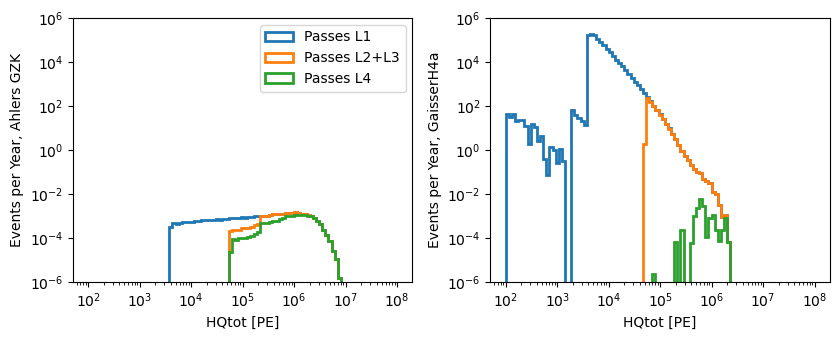

In [18]:
bins = np.logspace(2,8,100)

fig = plt.figure(figsize=(8.5,3.5))
ax_juliet = fig.add_subplot(1,2,1)
ax_corsika = fig.add_subplot(1,2,2)

ax_juliet.hist(
    juliet_charge_L2, weights= juliet_weights_L2,
    bins=bins, label='Passes L1', histtype='step', lw=2
)
ax_juliet.hist(
    juliet_charge_L3, weights= juliet_weights_L3,
    bins=bins, label='Passes L2+L3', histtype='step', lw=2
)
ax_juliet.hist(
    juliet_charge_L4, weights= juliet_weights_L4,
    bins=bins, label='Passes L4', histtype='step', lw=2
)

ax_corsika.hist(
    corsika_charge_L2, weights= corsika_weights_L2,
    bins=bins, label='Passes L1', histtype='step', lw=2
)
ax_corsika.hist(
    corsika_charge_L3, weights= corsika_weights_L3,
    bins=bins, label='Passes L2+L3', histtype='step', lw=2
)
ax_corsika.hist(
    corsika_charge_L4, weights= corsika_weights_L4,
    bins=bins, label='Passes L4', histtype='step', lw=2
)

for ax in [ax_juliet, ax_corsika]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('HQtot [PE]')

ax_juliet.set_ylabel('Events per Year, Ahlers GZK')
ax_juliet.legend()
ax_juliet.set_ylim([1E-3, 3E-2])
ax_juliet.set_ylim([1E-6, 1E6])

ax_corsika.set_ylabel('Events per Year, GaisserH4a')
ax_corsika.set_ylim([1E-6, 1E6])
# ax.corsika.set_ylabel('')
    
plt.tight_layout()
# plt.subplots_adjust(wspace=0.45)
fig.savefig('cut_levels.png', dpi=300)


In [17]:
print(np.sum(corsika_weights_L4)*12)
print(np.sum(juliet_weights_L4)*12)

0.19067581711584197
0.20967898625603787
